# Image Processing using the SSBD-OMERO API

In [400]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# HTTP library
import requests

# Stream of in-memory bytes
from io import BytesIO
# Pillow library
from PIL import Image
# OpenCV library
import cv2

from skimage.segmentation import active_contour

print (cv2.__version__)
# tested Python 2 or 3 + OpenCV v 3.2.0

3.2.0


# 1. Check a HTTP session to SSBD using the requests library

In [401]:
SSBD_BASE_URL = "http://ssbd.qbic.riken.jp/image"

url = SSBD_BASE_URL
if requests.session().get(url).status_code == 200:
    print("Successfully connected to SSBD")
else:
    print("Failed to connect to SSBD")
print(url)

Successfully connected to SSBD
http://ssbd.qbic.riken.jp/image


# 2. Get image 

http://ssbd.qbic.riken.jp/image/webgateway/render_image/25021/30/0


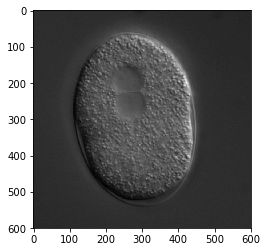

In [403]:
# Sample in Kyoda imagesets
IMAGE_ID = 25021
Z = 30
T = 0

# Sample in Takayama imagesets
#IMAGE_ID = 36874
#Z = 0
#T = 0

TMP_URL = "{base}/webgateway/render_image/{image_id}/{z}/{t}"
qs = {'base': SSBD_BASE_URL, 'image_id': IMAGE_ID, 'z': Z, 't': T}

url = TMP_URL.format(**qs)

r = requests.session().get(url)
if r.status_code != 200:
    print("access error (1)")
    sys.exit()

# PIL (RGB) -> OpenCV (Grayscale)
cv_img1 = cv2.cvtColor(np.array(Image.open(BytesIO(r.content))), cv2.COLOR_RGB2GRAY)
plt.imshow(cv_img1, 'gray')

print(url)

# 3. Check image metadata

In [404]:
TMP_URL = "{base}/webclient/imgData/{image_id}/"
qs = {'base': SSBD_BASE_URL, 'image_id': IMAGE_ID}
url = TMP_URL.format(**qs)

r = requests.session().get(url)
if r.status_code != 200:
    print("access error")
    sys.exit()

metadata = r.json()

print (url)
print ("ProjectName:", metadata['meta']['projectName'])
print ("Dataset:", metadata['meta']['datasetName'])
print ("X:", metadata['size']['width'])
print ("Y:", metadata['size']['height'])
print ("Z:", metadata['size']['z'])
print ("T:", metadata['size']['t'])
print ("C:", metadata['size']['c'])
print ("PixelsType: ", metadata['meta']['pixelsType'])
print ("PixwlRange: ", metadata['pixel_range'][1])

print ("\n", metadata)

http://ssbd.qbic.riken.jp/image/webclient/imgData/25021/
ProjectName: 2-Kyoda-WormEmbryoRNAi
Dataset: wt_N2_030131_01
X: 600
Y: 600
Z: 66
T: 1
C: 1
PixelsType:  uint16
PixwlRange:  65535

 {'init_zoom': 0, 'tiles': False, 'perms': {'canAnnotate': False, 'canEdit': False, 'canDelete': False, 'canLink': False}, 'rdefs': {'defaultT': 0, 'model': 'greyscale', 'invertAxis': False, 'projection': 'normal', 'defaultZ': 33}, 'pixel_range': [0, 65535], 'interpolate': True, 'channels': [{'color': '808080', 'emissionWave': None, 'label': '0', 'window': {'max': 2538.0, 'end': 2538.0, 'start': 435.0, 'min': 435.0}, 'active': True, 'reverseIntensity': False}], 'meta': {'projectName': '2-Kyoda-WormEmbryoRNAi', 'imageId': 25021, 'imageAuthor': 'public data', 'imageTimestamp': 1478871804.0, 'pixelsType': 'uint16', 'datasetId': 140, 'projectDescription': 'See details in Kyoda et al. (2013) Nucleic Acids Res 41, D732-D737', 'datasetName': 'wt_N2_030131_01', 'wellSampleId': '', 'projectId': 1, 'imageDescri

# 4. Get image ROI

http://ssbd.qbic.riken.jp/image/webgateway/render_image_region/25021/30/0/?region=150,130,200,200


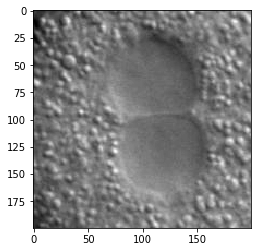

In [405]:
x = 0
y = 0
w  = 200
h  = 200
if IMAGE_ID == 36874:
    x = 100
    y = 100
    w  = 100
    h  = 100
elif IMAGE_ID == 25021:
    x = 150
    y = 130
    w  = 200
    h  = 200

TMP_URL = "{base}/webgateway/render_image_region/{image_id}/{z}/{t}/?region={x},{y},{w},{h}"
qs = {'base': SSBD_BASE_URL, 'image_id': IMAGE_ID, 'z': Z, 't': T, 'x': x, 'y': y, 'w': w, 'h': h}
url = TMP_URL.format(**qs)
r = requests.session().get(url)

print(url)
cv_img1_roi = cv2.cvtColor(np.array(Image.open(BytesIO(r.content))), cv2.COLOR_RGB2GRAY)
plt.imshow(cv_img1_roi, 'gray')


# 5. Binalize image using its metadata

maxPixel= 65535 thresh= 60.0


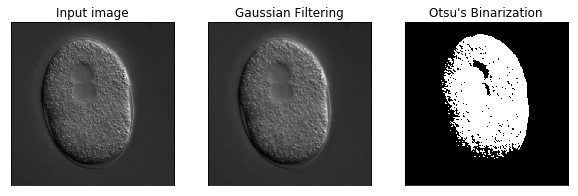

In [407]:
# Filterd
cv_img2 = cv2.GaussianBlur(cv_img1, (5,5), 0)

maxPixel = int(metadata['pixel_range'][1])
ret, cv_img3 = cv2.threshold(cv_img2, 0, maxPixel, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
print ("maxPixel=", maxPixel, "thresh=", ret)
# thresh = ??
#ret, cv_img3 = cv2.threshold(cv_img2, thresh, maxPixel, cv2.THRESH_BINARY)

titles = ['Input image', "Gaussian Filtering", "Otsu's Binarization"]
images = [cv_img1, cv_img2, cv_img3]

plt.figure(figsize=(10,3))
for i in range(0, 3):
    plt.subplot(1, 3, i+1)
    plt.imshow(images[i], 'gray')
    plt.title(titles[i])
    plt.xticks([]), plt.yticks([])

plt.savefig('result1.tiff')


#  6. Extract contours

#contours= 273 , #hierarchy= 1
max_i= 272 max_area= 99654.0


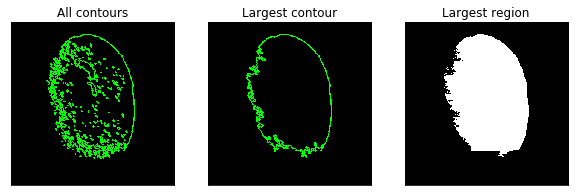

In [408]:
ret,contours,hierarchy = cv2.findContours(cv_img3, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
print("#contours=",len(contours), ", #hierarchy=", len(hierarchy))

max_i = None
max_area = None
for i in range(0, len(contours)):
    area = cv2.contourArea(contours[i])
    #print(i, area)
    if max_area == None or area > max_area:
        max_area = area
        max_i = i
print ("max_i=", max_i, "max_area=", max_area)

size = metadata['size']['height'], metadata['size']['width'], 3
#print (size)

img0 = cv2.drawContours(np.zeros(size, dtype=np.uint8), contours, -1, (0,255,0), 3)
img1 = cv2.drawContours(np.zeros(size, dtype=np.uint8), contours[max_i], -1, (0,255,0), 3)
img2 = cv2.fillConvexPoly(np.zeros(size, dtype=np.uint8), contours[max_i], (255,255,255))

titles = ['All contours', 'Largest contour', "Largest region"]
images = [img0, img1, img2]

plt.figure(figsize=(10,3))
for i in range(0, 3):
    plt.subplot(1, 3, i+1)
    plt.imshow(images[i])
    plt.title(titles[i])
    plt.xticks([]), plt.yticks([])

plt.savefig('result2.tiff')

# Active contour model (snakes)

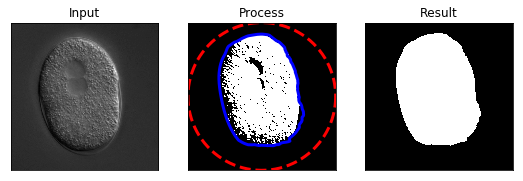

In [412]:
h = metadata['size']['height']
w = metadata['size']['width']

s = np.linspace(0, 2*np.pi, 300)
x = int(w/2)+int(w/2)*np.cos(s)
y = int(h/2)+int(h/2)*np.sin(s)
init = np.array([x, y]).T

snake = active_contour(cv_img3, init, alpha=0.01, beta=2, gamma=0.001)
#snake = active_contour(cv_img3, init, alpha=0.04, beta=2, gamma=0.001)

c = []
for s in snake:
    c.append([[s[0], s[1]]])
contour = np.array(c, dtype=np.int32) # float -> int
#print ("snake.shape", snake.shape)
#print ("contour.shape", contour.shape)

cv_img4 = cv2.fillConvexPoly(np.zeros(size, dtype=np.uint8), contour, (255,255,255))

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(9, 3))
ax0.imshow(cv_img1, cmap=plt.cm.gray)
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_title("Input")
ax0.axis([0, cv_img1.shape[1], cv_img1.shape[0], 0])
ax1.imshow(cv_img3, cmap=plt.cm.gray)
ax1.plot(init[:, 0], init[:, 1], '--r', lw=3)
ax1.plot(snake[:, 0], snake[:, 1], '-b', lw=3)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title("Process")
ax1.axis([0, cv_img3.shape[1], cv_img3.shape[0], 0])
ax2.imshow(cv_img4, cmap=plt.cm.gray)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title("Result")
ax2.axis([0, cv_img4.shape[1], cv_img4.shape[0], 0])
plt.savefig('result3.tiff')

In [410]:
vec = np.array(contour, dtype=np.int).reshape((contour.shape[0], contour.shape[2]))
#print (vec)
np.savetxt('output.csv',vec,delimiter=',', fmt='%d', header="x,y")